In [1]:
import numpy as np
from functions import *

In [2]:
T = 1000
T_test = 300

A_std_noise = 0.05
pi_std_noise = 0.05
mus_std_noise = [2.0, 0.5] # temp, rain level
Sigmas_std_noise = 0.02

# columns and rows indexed by
# (warm & rain, warm & dry, cold & rain, cold & dry)

# M x M
A_real = np.array([
    [0.6, 0.3, 0.05, 0.05],
    [0.2, 0.7, 0.05, 0.05],
    [0.1, 0.1, 0.7, 0.1],
    [0.05, 0.05, 0.2, 0.7]
    ], dtype=np.float32)

# M x N
mus_real = np.array([
    [20, 5],    # Warm & Rain
    [22, 0],    # Warm & Dry
    [5, 7],     # Cold & Rain
    [3, 0]      # Cold & Dry
], dtype=np.float32)

# M x N x N
Sigma_real = np.array([
    [[3, 0], [0, 2]],
    [[2, 0], [0, 1]],
    [[4, 0], [0, 3]],
    [[3, 0], [0, 1]]
], dtype=np.float32)

# M
pi_real = np.full(4, 0.25)

observations_total = np.zeros((T + T_test, 2))
states_total = np.zeros(T + T_test, dtype=int)

states_total[0] = np.random.choice(4)
observations_total[0, :] = np.random.multivariate_normal(mus_real[states_total[0], :], Sigma_real[states_total[0], :, :])

for t in range(1, T + T_test):
    # sample next state according to transition probabilities from A_real
    states_total[t] = int(np.random.choice(4, p=A_real[states_total[t-1], :]))
    observations_total[t] = np.random.multivariate_normal(mus_real[states_total[t], :], Sigma_real[states_total[t], :, :])

# split data in training and testing set
observations_train = observations_total[:T, :]
observations_test = observations_total[T:, :]
states_train = states_total[:T]
states_test = states_total[T:]

log_B_real = compute_b(mus_real, Sigma_real, observations_train, T, 4)
B_real = np.exp(log_B_real)
print('b real:'); print(B_real)

print('states:'); print(states_total)
print()
print('observations:'); print(observations_total)

b real:
[[4.47018565e-02 1.85612730e-10 1.61365512e-14 2.23991473e-31]
 [3.96538454e-04 1.00033344e-02 1.08058560e-15 2.43569588e-20]
 [1.32039339e-05 9.04257683e-03 4.11778772e-17 1.80376429e-20]
 ...
 [1.60316049e-35 1.45742007e-54 8.12836371e-09 5.48376231e-03]
 [3.41479122e-27 2.31487810e-44 1.20434710e-05 7.57270789e-02]
 [2.45302950e-28 1.01239604e-42 1.03895889e-07 2.50657486e-02]]
states:
[0 1 1 ... 2 3 3]

observations:
[[20.11972049  6.21917121]
 [18.99081566  0.55962228]
 [19.01999743 -0.77621726]
 ...
 [ 4.43008023  6.28874477]
 [ 2.48041639 -1.35512507]
 [-0.16980403  1.36032041]]


In [3]:
pct_change_ll_tol = 0.01
n_attempts = 100
max_attempt_per_iter = 10

# these will store data from every run
# structure: list of lists (inner list = data per iteration)
ll_list = []
diff_norms_A = []
diff_norms_B = []
diff_norms_pi = []

# these will store data from every run
# stucture: list of floats (one per attempt, not one per iteration)
pct_states_matched_viterbi = []
frac_correct_states_predicted_list = []

# initialize parameters for estimation (pretend we don't know the true values)
A = A_real.copy()
pi = pi_real.copy()

all_predicted_obs = []

for attempt in range(n_attempts):

    prev_ll = 1.0
    log_ll = 2.0
    
    # add noise to A
    A += np.random.normal(0, A_std_noise, (4, 4))
    A = np.clip(A, a_min=0.05, a_max=0.95)
    A_rowsum = A.sum(axis=1)
    for i in range(4):
        A[:, i] /= A_rowsum
    loga = np.log(A)

    # add noise to pi
    pi += np.random.normal(0, pi_std_noise, 4)
    pi = np.clip(pi, a_min=0.05, a_max=0.95)
    pi /= pi.sum()
    logpi = np.log(pi)

    # add noise to mus
    mus = np.empty(mus_real.shape)
    mus[:, 0] = np.clip(mus_real[:, 0] + np.random.normal(0, mus_std_noise[0], size=4), a_min=0, a_max=30)
    mus[:, 1] = np.clip(mus_real[:, 1] + np.random.normal(0, mus_std_noise[1], size=4), a_min=0, a_max=30)
    # add noise to Sigma
    Sigma = Sigma_real.copy()
    for m in range(4):
        Sigma[m, :, :] = np.clip(Sigma_real[m, :, :] + Sigmas_std_noise * np.eye(2), a_min=0, a_max=10)

    # compute logB
    logb = compute_b(mus, Sigma, observations_train, T, 4)

    # store some metrics for each iterion step
    this_diff_norms_A = []
    this_diff_norms_B = []
    this_diff_norms_pi = []
    this_attempt_ll_list = []

    this_attempt_count = 0

    while abs(prev_ll - log_ll) / prev_ll > pct_change_ll_tol and this_attempt_count < max_attempt_per_iter:
        prev_ll = log_ll

        # E step
        logalpha, scaling = forward(loga, logb, T, 4, logpi)
        logbeta = backward(loga, logb, T, 4, scaling)
        loggamma = compute_gamma(logalpha, logbeta, T, 4)
        logxi = compute_xi(logalpha, logbeta, loga, logb, T, 4)

        # M step
        loga = compute_a(loggamma, logxi, T, 4)
        mus, Sigmas = compute_mus_sigmas(loggamma, observations_train, T, 4, 2)
        logb = compute_b(mus, Sigmas, observations_train, T, 4)
        logpi = loggamma[0, :]

        # storing metrics for each iteration
        log_ll = np.sum(scaling)
        this_attempt_ll_list.append(log_ll)
        this_diff_norms_A.append(np.linalg.norm(np.exp(loga) - A_real))
        this_diff_norms_B.append(np.linalg.norm(np.exp(logb) - B_real))
        this_diff_norms_pi.append(np.linalg.norm(np.exp(logpi) - pi_real))

        this_attempt_count += 1

    A = np.exp(loga)
    A /= A.sum(axis=1, keepdims=True)
    B = np.exp(logb)
    B /= B.sum(axis=1, keepdims=True)
    pi = np.exp(logpi)
    pi /= pi.sum()

    A = np.clip(A, 1e-10, 1)
    B = np.clip(B, 1e-10, 1)

    # store data from this attempt
    ll_list.append(this_attempt_ll_list)
    diff_norms_A.append(this_diff_norms_A)
    diff_norms_B.append(this_diff_norms_B)
    diff_norms_pi.append(this_diff_norms_pi)

    # test model on training data

    # first, use the Hungarian method to match the most likely B_real orientation, given the
    # orientation of B
    perm = match_states_by_gaussians(mus, Sigma, mus_real, Sigma_real)
    pi_p, A_p, mus_p, Sigma_p = permute_model(pi, A, mus, Sigma, perm)
    # print('pi p, A p, mus & sigmas:'); print(pi_p); print(A_p); print(mus); print(Sigma)

    logpi_p = np.log(pi_p)
    loga_p = np.log(A_p)
    logb_p = compute_b(mus_p, Sigma_p, observations_train, T, 4)

    # assuming we have access to the future observations, we will test the model using the viterbi path
    # algorithm, to see how well it can predict the hidden state variables, given these observations
    predicted_states_vit, p = viterbi(logpi_p, logb_p, loga_p, T_test, 4)
    pct_matched = 1 - np.count_nonzero(np.logical_xor(predicted_states_vit, states_test)) / len(predicted_states_vit)
    pct_states_matched_viterbi.append(pct_matched)

    # assuming we are at time T and we wanted to predict the future states and observations up untill
    # t = T_test, we will try to predict these values and see how well the model generalizes
    predicted_obs = np.empty((T_test, 2))
    predicted_states = np.empty(T_test, dtype=int)

    B_p = np.exp(logb_p)
    states_p_dist = np.exp(loggamma[-1, :])
    predicted_states[0] = np.argmax(states_p_dist)
    predicted_obs[0, :] = np.argmax(mus, axis=0)

    # generate prediction states and observations using A and B
    for k in range(1, T_test):

        # prediction of states
        states_p_dist = states_p_dist @ A_p
        states_p_dist /= states_p_dist.sum()
        predicted_states[k] = np.argmax(states_p_dist)
        # determine the predicted observation by taking the most likely observation, given the
        # predicted state value
        predicted_obs[k, :] = states_p_dist @ mus

    # save the fraction of correctly predicted states and observations
    frac_correct_states_predicted = 1 - np.count_nonzero(np.logical_xor(states_test, predicted_states)) / len(predicted_states)

    frac_correct_states_predicted_list.append(frac_correct_states_predicted)
    all_predicted_obs.append(predicted_obs)

RECEIVED:
(1000, 4)
(1000, 2)
RECEIVED:
(1000, 4)
(1000, 2)
COST MATRIX:
[[6.02851091e-01 1.31891399e+01 7.44148377e+01 1.15029037e+02]
 [1.76257858e+01 1.52633417e-01 1.34170025e+02 1.45331979e+02]
 [4.54852352e+01 9.88536203e+01 2.42909321e+00 2.61765603e+01]
 [1.12732819e+02 1.47088334e+02 3.39836066e+01 1.27910200e-02]]
RECEIVED:
(1000, 4)
(1000, 2)
RECEIVED:
(1000, 4)
(1000, 2)
COST MATRIX:
[[1.04450124e+00 1.69207420e+01 5.83422823e+01 9.41957051e+01]
 [1.87585223e+01 5.22617733e-02 1.37053326e+02 1.47386138e+02]
 [6.44075696e+01 1.32772191e+02 1.73805451e-01 2.85908764e+01]
 [8.71932095e+01 1.12486513e+02 3.18702537e+01 2.18279841e+00]]
RECEIVED:
(1000, 4)
(1000, 2)
RECEIVED:
(1000, 4)
(1000, 2)
COST MATRIX:
[[1.07343094e+00 1.68409760e+01 5.82940671e+01 9.39589528e+01]
 [1.92378573e+01 2.81990000e-02 1.37832748e+02 1.47625785e+02]
 [6.43994563e+01 1.32771738e+02 1.73157934e-01 2.86064117e+01]
 [8.94002719e+01 1.15038030e+02 3.23283249e+01 1.86787354e+00]]
RECEIVED:
(1000, 4)
(1

Plot the log-likelyhood values of each attempt

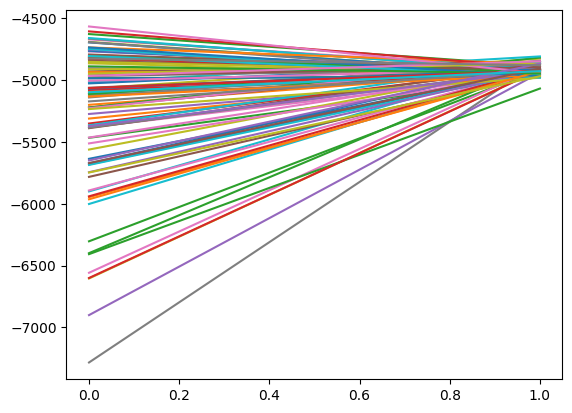

In [4]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for i in range(n_attempts):
    ax.plot(list(range(len(ll_list[i]))), ll_list[i])

plt.show()

Make a bar chart out of the fraction of correctly predicted states, given the true observations from $t=T_{\text{test}}$ onwards

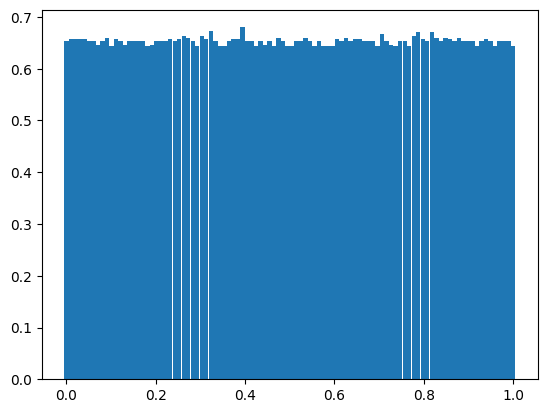

maximum pct correct: 0.6799999999999999 from attempt 40
minimum pct correct: 0.6433333333333333 from attempt 11


In [5]:
plt.bar(np.linspace(0, 1, n_attempts), pct_states_matched_viterbi, width=1/(1 + n_attempts))
plt.show()

print('maximum pct correct:', np.max(pct_states_matched_viterbi), 'from attempt', np.argmax(pct_states_matched_viterbi) + 1)
print('minimum pct correct:', np.min(pct_states_matched_viterbi), 'from attempt', np.argmin(pct_states_matched_viterbi) + 1)

Plot the fraction of correctly predicted states, from the propelled distribution of states by the model

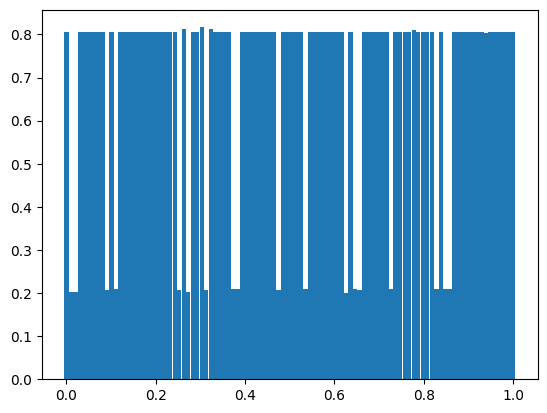

In [6]:
fig, ax = plt.subplots()
ax.bar(np.linspace(0, 1, n_attempts), frac_correct_states_predicted_list, width=1/(1 + n_attempts))
plt.show()